# PART 1B: GOALS ANALYSIS

## Objective
Explore goal-scoring patterns using descriptive statistics, comparing historical season-end data (15 seasons at GW38) with current season progression (GW 3-7). Understand what goal totals define Top 4, mid-table, and relegation zones, and assess current teams' pacing.

## Context
- **Historical data:** 15 complete seasons (2010-2011 through 2024-2025) with GW38 end-of-season totals
- **Current data:** 2025-2026 season with weekly tracking from GW 3-7 (is_current = true at GW7)
- **Goal:** Learn what goal patterns separate winners from losers using descriptive statistics

## Section 1: Setup and Data Loading

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Database connection
db_path = "../../../data/premierleague_analytics.duckdb"
conn = duckdb.connect(db_path, read_only=True)

print("=" * 80)
print("PART 1B: GOALS ANALYSIS")
print("=" * 80)
print(f"📊 Database: {db_path}")
print(f"⏰ Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

PART 1B: GOALS ANALYSIS
📊 Database: ../../../data/premierleague_analytics.duckdb
⏰ Analysis started: 2025-10-15 14:15:42



## Section 2: Load Historical Data (GW38)

In [2]:
print("📚 Loading Historical Data (15 seasons, GW38 end-of-season totals)...")

# Load historical season-end data
historical = conn.execute("""
    SELECT
        season,
        squad_name,
        gameweek,
        matches_played,
        goals,
        goals_against,
        (goals - goals_against) as goal_difference,
        wins,
        draws,
        losses,
        (wins * 3 + draws) as points
    FROM analytics_squads
    WHERE gameweek = 38
    ORDER BY season DESC, (wins * 3 + draws) DESC
""").fetchdf()

print(f"✅ Loaded {len(historical)} historical squad records")
print(f"📅 Seasons covered: {historical['season'].nunique()} seasons")
print(f"   Range: {historical['season'].min()} to {historical['season'].max()}")
print(f"🏆 Squads represented: {historical['squad_name'].nunique()} unique squads")
print()

# Display sample
print("Sample historical records:")
print(historical.head(3))
print()

📚 Loading Historical Data (15 seasons, GW38 end-of-season totals)...
✅ Loaded 300 historical squad records
📅 Seasons covered: 15 seasons
   Range: 2010-2011 to 2024-2025
🏆 Squads represented: 41 unique squads

Sample historical records:
      season       squad_name  gameweek  matches_played  goals  goals_against  \
0  2024-2025        Liverpool        38              38     85             41   
1  2024-2025          Arsenal        38              38     67             34   
2  2024-2025  Manchester City        38              38     71             44   

   goal_difference  wins  draws  losses  points  
0               44    25      9       4      84  
1               33    20     14       4      74  
2               27    21      8       9      71  



## Section 3: Load Current Season Data (GW 3-7)

In [3]:
print("📊 Loading Current Season Data (2025-2026, GW 3-7)...")

# Load current season progression
current_all = conn.execute("""
    SELECT
        season,
        squad_name,
        gameweek,
        matches_played,
        goals,
        goals_against,
        (goals - goals_against) as goal_difference,
        wins,
        draws,
        losses,
        (wins * 3 + draws) as points
    FROM analytics_squads
    WHERE season = '2025-2026'
    ORDER BY gameweek, squad_name
""").fetchdf()

# Get current snapshot (GW7, is_current = true)
current = conn.execute("""
    SELECT
        season,
        squad_name,
        gameweek,
        matches_played,
        goals,
        goals_against,
        (goals - goals_against) as goal_difference,
        wins,
        draws,
        losses,
        (wins * 3 + draws) as points
    FROM analytics_squads
    WHERE is_current = true
    ORDER BY (wins * 3 + draws) DESC, (goals - goals_against) DESC
""").fetchdf()

print(f"✅ Current season records: {len(current_all)} total records")
print(f"   Gameweeks: GW{current_all['gameweek'].min()} to GW{current_all['gameweek'].max()}")
print(f"✅ Current snapshot (GW7): {len(current)} squads")
print()

# Display current leaders
print("Current season leaders (GW7):")
print(current[['squad_name', 'matches_played', 'goals', 'goals_against', 'goal_difference', 'points']].head(5))
print()

📊 Loading Current Season Data (2025-2026, GW 3-7)...
✅ Current season records: 100 total records
   Gameweeks: GW3 to GW7
✅ Current snapshot (GW7): 20 squads

Current season leaders (GW7):
        squad_name  matches_played  goals  goals_against  goal_difference  \
0          Arsenal               7     14              3               11   
1        Liverpool               7     13              9                4   
2        Tottenham               7     12              5                7   
3      Bournemouth               7     11              8                3   
4  Manchester City               7     13              6                7   

   points  
0      16  
1      15  
2      14  
3      14  
4      13  



## Section 4: Historical Goals Analysis

### 4.1 Descriptive Statistics for Goals Scored

In [4]:
print("=" * 80)
print("SECTION 4: HISTORICAL GOALS ANALYSIS (GW38)")
print("=" * 80)
print()

# Calculate descriptive statistics
goals_stats = historical['goals'].describe()

print("📊 DESCRIPTIVE STATISTICS - GOALS SCORED (Full Season)")
print("-" * 80)
print(f"Count:        {goals_stats['count']:.0f} seasons")
print(f"Mean:         {goals_stats['mean']:.2f} goals")
print(f"Median:       {goals_stats['50%']:.2f} goals")
print(f"Std Dev:      {goals_stats['std']:.2f} goals")
print(f"Min:          {goals_stats['min']:.0f} goals")
print(f"25th %ile:    {goals_stats['25%']:.2f} goals")
print(f"75th %ile:    {goals_stats['75%']:.2f} goals")
print(f"Max:          {goals_stats['max']:.0f} goals")
print(f"Range:        {goals_stats['max'] - goals_stats['min']:.0f} goals")
print()

# Additional statistics
mode_goals = historical['goals'].mode()
variance = historical['goals'].var()

print(f"Mode:         {mode_goals.iloc[0] if len(mode_goals) > 0 else 'N/A'} goals")
print(f"Variance:     {variance:.2f}")
print()

SECTION 4: HISTORICAL GOALS ANALYSIS (GW38)

📊 DESCRIPTIVE STATISTICS - GOALS SCORED (Full Season)
--------------------------------------------------------------------------------
Count:        300 seasons
Mean:         51.35 goals
Median:       48.00 goals
Std Dev:      16.58 goals
Min:          19 goals
25th %ile:    40.00 goals
75th %ile:    62.00 goals
Max:          103 goals
Range:        84 goals

Mode:         41 goals
Variance:     275.00



### 4.2 Goals Distribution Visualization

✅ Saved: historical_goals_distribution.png

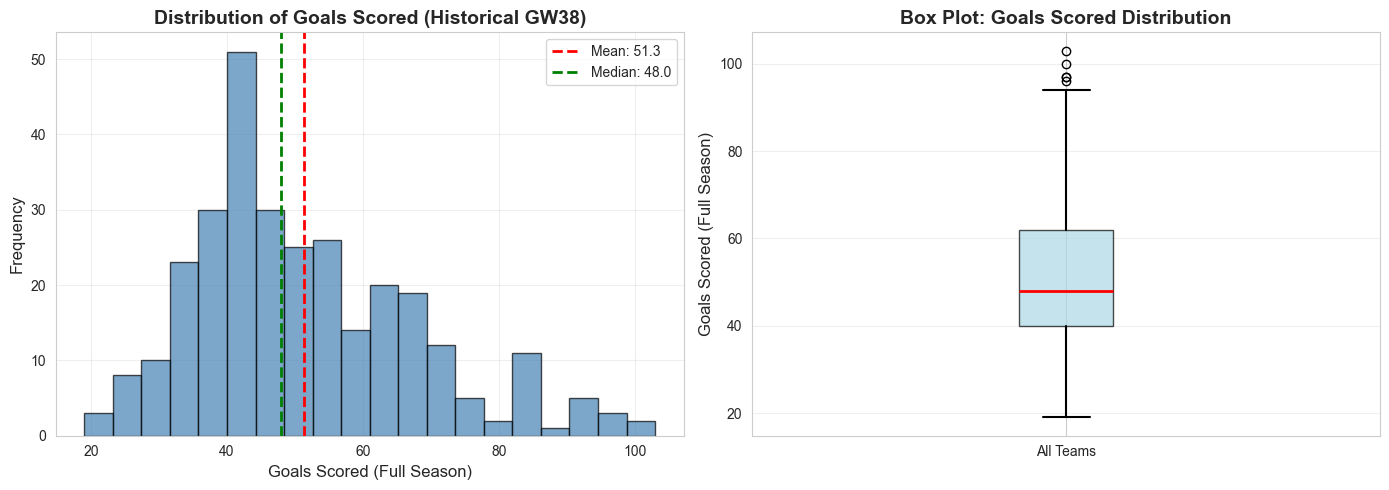

In [5]:
# Create output directory
output_dir = Path("../../outputs/02_goals_analysis")
output_dir.mkdir(parents=True, exist_ok=True)

# Create histogram of goals scored
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(historical['goals'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(historical['goals'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {historical["goals"].mean():.1f}')
axes[0].axvline(historical['goals'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {historical["goals"].median():.1f}')
axes[0].set_xlabel('Goals Scored (Full Season)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Goals Scored (Historical GW38)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(historical['goals'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
axes[1].set_ylabel('Goals Scored (Full Season)', fontsize=12)
axes[1].set_title('Box Plot: Goals Scored Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(['All Teams'])

plt.tight_layout()
plt.savefig(output_dir / "historical_goals_distribution.png", dpi=300, bbox_inches='tight')
print("✅ Saved: historical_goals_distribution.png")
plt.show()

### 4.3 Check Distribution Shape

In [6]:
# Check if distribution is normal or skewed
from scipy import stats

skewness = stats.skew(historical['goals'])
kurtosis = stats.kurtosis(historical['goals'])

print("📈 DISTRIBUTION SHAPE ANALYSIS")
print("-" * 80)
print(f"Skewness:     {skewness:.3f}")
if abs(skewness) < 0.5:
    skew_interp = "Approximately symmetric (normal-like)"
elif skewness > 0:
    skew_interp = "Right-skewed (tail on high end)"
else:
    skew_interp = "Left-skewed (tail on low end)"
print(f"              {skew_interp}")
print()

print(f"Kurtosis:     {kurtosis:.3f}")
if abs(kurtosis) < 0.5:
    kurt_interp = "Mesokurtic (normal-like tails)"
elif kurtosis > 0:
    kurt_interp = "Leptokurtic (heavy tails, more outliers)"
else:
    kurt_interp = "Platykurtic (light tails, fewer outliers)"
print(f"              {kurt_interp}")
print()

📈 DISTRIBUTION SHAPE ANALYSIS
--------------------------------------------------------------------------------
Skewness:     0.772
              Right-skewed (tail on high end)

Kurtosis:     0.235
              Mesokurtic (normal-like tails)



## Section 5: Goals by Final Position

### 5.1 Create Position Tiers

In [7]:
print("=" * 80)
print("SECTION 5: GOALS BY FINAL POSITION TIERS")
print("=" * 80)
print()

# Calculate final position within each season
historical['final_position'] = historical.groupby('season')['points'].rank(method='min', ascending=False)
historical['final_position'] = historical['final_position'].astype(int)

# Assign tiers
def get_tier(position):
    if position <= 4:
        return 'Top 4'
    elif position <= 10:
        return 'Upper Mid-Table (5-10)'
    elif position <= 17:
        return 'Lower Mid-Table (11-17)'
    else:
        return 'Relegation Zone (18-20)'

historical['tier'] = historical['final_position'].apply(get_tier)

# Calculate stats by tier
tier_stats = historical.groupby('tier')['goals'].describe()
tier_stats = tier_stats.reindex(['Top 4', 'Upper Mid-Table (5-10)', 'Lower Mid-Table (11-17)', 'Relegation Zone (18-20)'])

print("📊 GOALS SCORED BY FINAL POSITION TIER")
print("-" * 80)
print(tier_stats)
print()

SECTION 5: GOALS BY FINAL POSITION TIERS

📊 GOALS SCORED BY FINAL POSITION TIER
--------------------------------------------------------------------------------
                         count       mean        std   min   25%   50%   75%  \
tier                                                                           
Top 4                     61.0  74.983607  12.509319  46.0  67.0  71.0  84.0   
Upper Mid-Table (5-10)    95.0  53.789474   9.996696  35.0  46.0  53.0  60.0   
Lower Mid-Table (11-17)   99.0  42.141414   6.914950  25.0  37.5  42.0  47.0   
Relegation Zone (18-20)   45.0  34.400000   7.972681  19.0  28.0  33.0  40.0   

                           max  
tier                            
Top 4                    103.0  
Upper Mid-Table (5-10)    83.0  
Lower Mid-Table (11-17)   61.0  
Relegation Zone (18-20)   54.0  



### 5.2 Visualize Goals by Tier

✅ Saved: goals_by_position_tier.png


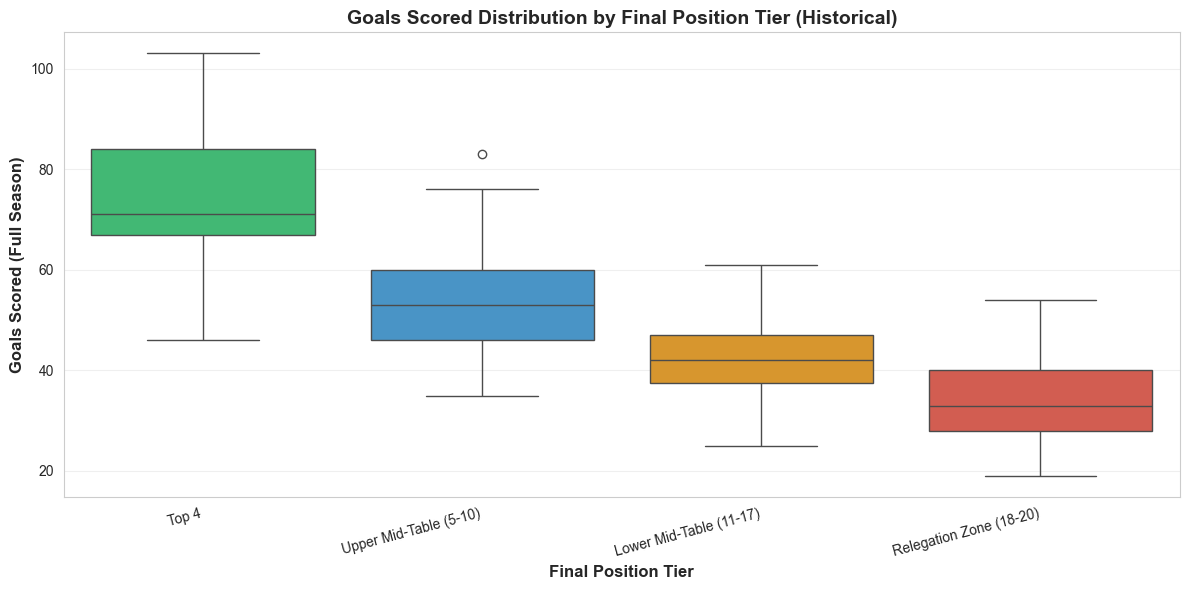

In [8]:
# Box plot by tier
fig, ax = plt.subplots(figsize=(12, 6))

tier_order = ['Top 4', 'Upper Mid-Table (5-10)', 'Lower Mid-Table (11-17)', 'Relegation Zone (18-20)']
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

sns.boxplot(data=historical, x='tier', y='goals', order=tier_order, palette=colors, ax=ax)
ax.set_xlabel('Final Position Tier', fontsize=12, fontweight='bold')
ax.set_ylabel('Goals Scored (Full Season)', fontsize=12, fontweight='bold')
ax.set_title('Goals Scored Distribution by Final Position Tier (Historical)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Rotate x labels
plt.xticks(rotation=15, ha='right')

plt.tight_layout()
plt.savefig(output_dir / "goals_by_position_tier.png", dpi=300, bbox_inches='tight')
print("✅ Saved: goals_by_position_tier.png")
plt.show()

### 5.3 Identify Thresholds

In [9]:
print("🎯 GOAL THRESHOLDS BY TIER")
print("-" * 80)

# Calculate key thresholds
top4_min = historical[historical['tier'] == 'Top 4']['goals'].min()
top4_avg = historical[historical['tier'] == 'Top 4']['goals'].mean()
top4_median = historical[historical['tier'] == 'Top 4']['goals'].median()

relegation_max = historical[historical['tier'] == 'Relegation Zone (18-20)']['goals'].max()
relegation_avg = historical[historical['tier'] == 'Relegation Zone (18-20)']['goals'].mean()
relegation_median = historical[historical['tier'] == 'Relegation Zone (18-20)']['goals'].median()

print(f"Top 4 Teams:")
print(f"  Minimum:  {top4_min:.0f} goals (weakest Top 4 team ever)")
print(f"  Median:   {top4_median:.0f} goals (typical Top 4)")
print(f"  Average:  {top4_avg:.1f} goals")
print()

print(f"Relegation Zone Teams:")
print(f"  Maximum:  {relegation_max:.0f} goals (best relegated team)")
print(f"  Median:   {relegation_median:.0f} goals (typical relegated)")
print(f"  Average:  {relegation_avg:.1f} goals")
print()

print(f"💡 Key Insight:")
print(f"   To be safe for Top 4: Need {top4_median:.0f}+ goals")
print(f"   To avoid relegation: Need {relegation_max:.0f}+ goals")
print()

🎯 GOAL THRESHOLDS BY TIER
--------------------------------------------------------------------------------
Top 4 Teams:
  Minimum:  46 goals (weakest Top 4 team ever)
  Median:   71 goals (typical Top 4)
  Average:  75.0 goals

Relegation Zone Teams:
  Maximum:  54 goals (best relegated team)
  Median:   33 goals (typical relegated)
  Average:  34.4 goals

💡 Key Insight:
   To be safe for Top 4: Need 71+ goals
   To avoid relegation: Need 54+ goals



## Section 6: Current Season Analysis

### 6.1 Current Goals Leaders (GW7)

In [10]:
print("=" * 80)
print("SECTION 6: CURRENT SEASON GOALS ANALYSIS (GW7)")
print("=" * 80)
print()

# Calculate goals per game
current['goals_per_game'] = current['goals'] / current['matches_played']
current['projected_season_goals'] = current['goals_per_game'] * 38

# Sort by goals
current_sorted = current.sort_values('goals', ascending=False).copy()

print("🏆 TOP 10 GOAL SCORERS (Current Season, GW7)")
print("-" * 80)
print(f"{'Rank':<6} {'Squad':<20} {'Goals':<8} {'Matches':<9} {'Goals/Game':<12} {'Projected'}")
print("-" * 80)

for idx, row in current_sorted.head(10).iterrows():
    rank = current_sorted.index.get_loc(idx) + 1
    print(f"{rank:<6} {row['squad_name']:<20} {row['goals']:<8.0f} {row['matches_played']:<9.0f} {row['goals_per_game']:<12.2f} {row['projected_season_goals']:.1f}")

print()

SECTION 6: CURRENT SEASON GOALS ANALYSIS (GW7)

🏆 TOP 10 GOAL SCORERS (Current Season, GW7)
--------------------------------------------------------------------------------
Rank   Squad                Goals    Matches   Goals/Game   Projected
--------------------------------------------------------------------------------
1      Arsenal              14       7         2.00         76.0
2      Manchester City      13       7         1.86         70.6
3      Chelsea              13       7         1.86         70.6
4      Liverpool            13       7         1.86         70.6
5      Tottenham            12       7         1.71         65.1
6      Bournemouth          11       7         1.57         59.7
7      Brighton             10       7         1.43         54.3
8      Brentford            9        7         1.29         48.9
9      Crystal Palace       9        7         1.29         48.9
10     Everton              9        7         1.29         48.9



### 6.2 Visualize Current Goals

✅ Saved: current_goals_leaders.png


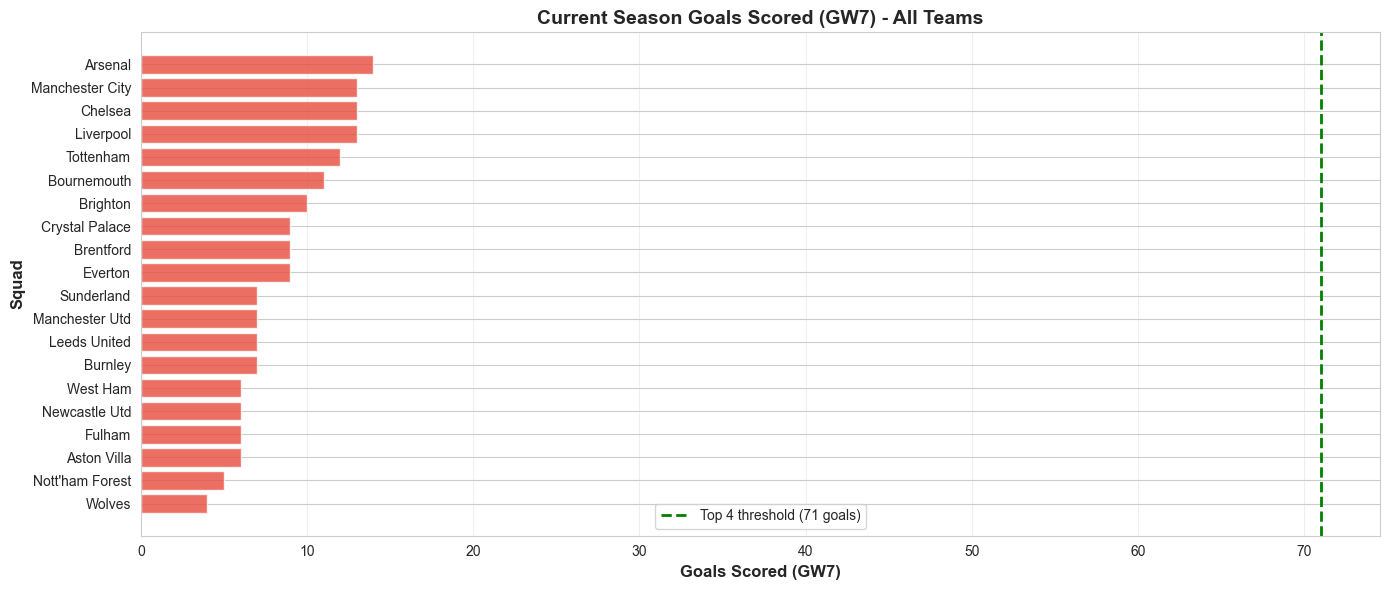

In [11]:
# Bar chart of current goals
fig, ax = plt.subplots(figsize=(14, 6))

current_sorted_plot = current_sorted.sort_values('goals', ascending=True)
colors_bar = ['#2ecc71' if g >= top4_median else '#f39c12' if g >= relegation_max else '#e74c3c' 
              for g in current_sorted_plot['goals']]

ax.barh(current_sorted_plot['squad_name'], current_sorted_plot['goals'], color=colors_bar, alpha=0.8)
ax.axvline(top4_median, color='green', linestyle='--', linewidth=2, label=f'Top 4 threshold ({top4_median:.0f} goals)')
ax.set_xlabel('Goals Scored (GW7)', fontsize=12, fontweight='bold')
ax.set_ylabel('Squad', fontsize=12, fontweight='bold')
ax.set_title('Current Season Goals Scored (GW7) - All Teams', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(output_dir / "current_goals_leaders.png", dpi=300, bbox_inches='tight')
print("✅ Saved: current_goals_leaders.png")
plt.show()

### 6.3 Project to Season End

In [12]:
print("📈 SEASON PROJECTIONS (Based on GW7 pace)")
print("-" * 80)

# Add tier based on projected goals
def get_projected_tier(proj_goals):
    if proj_goals >= top4_median:
        return 'On Top 4 Pace'
    elif proj_goals >= relegation_max:
        return 'Mid-Table Pace'
    else:
        return 'Relegation Pace'

current_sorted['projected_tier'] = current_sorted['projected_season_goals'].apply(get_projected_tier)

# Count by projected tier
tier_counts = current_sorted['projected_tier'].value_counts()

print(f"Teams on Top 4 pace:        {tier_counts.get('On Top 4 Pace', 0)}")
print(f"Teams on Mid-Table pace:    {tier_counts.get('Mid-Table Pace', 0)}")
print(f"Teams on Relegation pace:   {tier_counts.get('Relegation Pace', 0)}")
print()

# Show teams by projected tier
for tier in ['On Top 4 Pace', 'Mid-Table Pace', 'Relegation Pace']:
    teams = current_sorted[current_sorted['projected_tier'] == tier]['squad_name'].tolist()
    if teams:
        print(f"{tier}: {', '.join(teams)}")
print()

📈 SEASON PROJECTIONS (Based on GW7 pace)
--------------------------------------------------------------------------------
Teams on Top 4 pace:        1
Teams on Mid-Table pace:    6
Teams on Relegation pace:   13

On Top 4 Pace: Arsenal
Mid-Table Pace: Manchester City, Chelsea, Liverpool, Tottenham, Bournemouth, Brighton
Relegation Pace: Brentford, Crystal Palace, Everton, Sunderland, Manchester Utd, Leeds United, Burnley, West Ham, Newcastle Utd, Fulham, Aston Villa, Nott'ham Forest, Wolves



## Section 7: Goals Conceded Analysis

### 7.1 Historical Goals Against

In [13]:
print("=" * 80)
print("SECTION 7: GOALS CONCEDED ANALYSIS")
print("=" * 80)
print()

# Descriptive stats for goals against
goals_against_stats = historical['goals_against'].describe()

print("📊 DESCRIPTIVE STATISTICS - GOALS CONCEDED (Historical GW38)")
print("-" * 80)
print(f"Mean:         {goals_against_stats['mean']:.2f} goals")
print(f"Median:       {goals_against_stats['50%']:.2f} goals")
print(f"Std Dev:      {goals_against_stats['std']:.2f} goals")
print(f"Min:          {goals_against_stats['min']:.0f} goals (best defense)")
print(f"Max:          {goals_against_stats['max']:.0f} goals (worst defense)")
print()

# Goals against by tier
tier_defense = historical.groupby('tier')['goals_against'].describe()
tier_defense = tier_defense.reindex(['Top 4', 'Upper Mid-Table (5-10)', 'Lower Mid-Table (11-17)', 'Relegation Zone (18-20)'])

print("🛡️  GOALS CONCEDED BY TIER")
print("-" * 80)
print(tier_defense[['mean', '50%', 'min', 'max']])
print()

# Defensive thresholds
top4_defense_max = historical[historical['tier'] == 'Top 4']['goals_against'].max()
top4_defense_median = historical[historical['tier'] == 'Top 4']['goals_against'].median()

print(f"🎯 Top 4 Defensive Threshold:")
print(f"   Median conceded: {top4_defense_median:.0f} goals")
print(f"   Maximum conceded: {top4_defense_max:.0f} goals (worst Top 4 defense)")
print()

SECTION 7: GOALS CONCEDED ANALYSIS

📊 DESCRIPTIVE STATISTICS - GOALS CONCEDED (Historical GW38)
--------------------------------------------------------------------------------
Mean:         53.25 goals
Median:       53.00 goals
Std Dev:      13.51 goals
Min:          22 goals (best defense)
Max:          104 goals (worst defense)

🛡️  GOALS CONCEDED BY TIER
--------------------------------------------------------------------------------
                              mean   50%   min    max
tier                                                 
Top 4                    36.737705  36.0  22.0   61.0
Upper Mid-Table (5-10)   50.168421  50.0  29.0   74.0
Lower Mid-Table (11-17)  58.181818  58.0  44.0   79.0
Relegation Zone (18-20)  71.311111  73.0  51.0  104.0

🎯 Top 4 Defensive Threshold:
   Median conceded: 36 goals
   Maximum conceded: 61 goals (worst Top 4 defense)



### 7.2 Current Season Defense (GW7)

In [14]:
# Calculate current defensive stats
current_sorted_defense = current.sort_values('goals_against').copy()

print("🛡️  BEST DEFENSES (Current Season, GW7)")
print("-" * 80)
print(f"{'Rank':<6} {'Squad':<20} {'Conceded':<10} {'Goals/Game':<12} {'Projected'}")
print("-" * 80)

current_sorted_defense['goals_against_per_game'] = current_sorted_defense['goals_against'] / current_sorted_defense['matches_played']
current_sorted_defense['projected_conceded'] = current_sorted_defense['goals_against_per_game'] * 38

for idx, row in current_sorted_defense.head(10).iterrows():
    rank = current_sorted_defense.index.get_loc(idx) + 1
    print(f"{rank:<6} {row['squad_name']:<20} {row['goals_against']:<10.0f} {row['goals_against_per_game']:<12.2f} {row['projected_conceded']:.1f}")

print()

🛡️  BEST DEFENSES (Current Season, GW7)
--------------------------------------------------------------------------------
Rank   Squad                Conceded   Goals/Game   Projected
--------------------------------------------------------------------------------
1      Arsenal              3          0.43         16.3
2      Tottenham            5          0.71         27.1
3      Crystal Palace       5          0.71         27.1
4      Newcastle Utd        5          0.71         27.1
5      Manchester City      6          0.86         32.6
6      Sunderland           6          0.86         32.6
7      Everton              7          1.00         38.0
8      Aston Villa          7          1.00         38.0
9      Bournemouth          8          1.14         43.4
10     Liverpool            9          1.29         48.9



## Section 8: Goal Difference Analysis

### 8.1 Historical Goal Difference

SECTION 8: GOAL DIFFERENCE ANALYSIS

⚖️  GOAL DIFFERENCE BY TIER (Historical)
--------------------------------------------------------------------------------
                              mean   50%   min   max
tier                                                
Top 4                    38.245902  35.0  11.0  76.0
Upper Mid-Table (5-10)    3.621053   5.0 -19.0  29.0
Lower Mid-Table (11-17) -16.040404 -16.0 -37.0   6.0
Relegation Zone (18-20) -36.911111 -34.0 -73.0 -19.0



✅ Saved: goals_scatter_historical.png


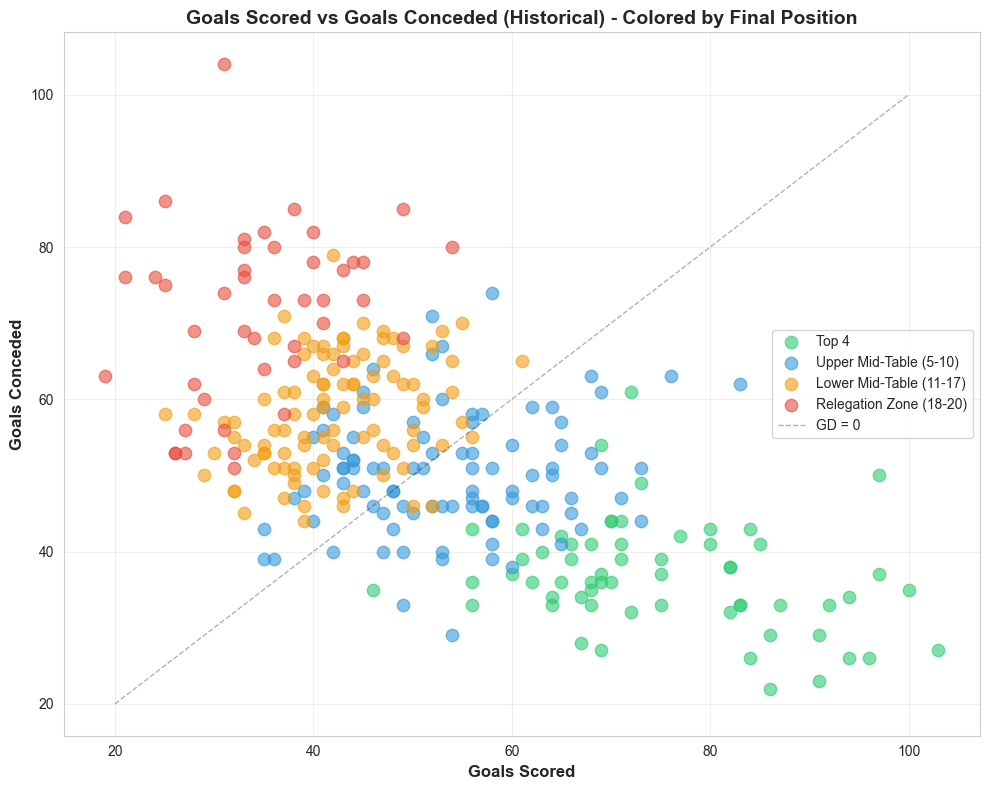

In [15]:
print("=" * 80)
print("SECTION 8: GOAL DIFFERENCE ANALYSIS")
print("=" * 80)
print()

# Goal difference by tier
tier_gd = historical.groupby('tier')['goal_difference'].describe()
tier_gd = tier_gd.reindex(['Top 4', 'Upper Mid-Table (5-10)', 'Lower Mid-Table (11-17)', 'Relegation Zone (18-20)'])

print("⚖️  GOAL DIFFERENCE BY TIER (Historical)")
print("-" * 80)
print(tier_gd[['mean', '50%', 'min', 'max']])
print()

# Scatter plot: Goals Scored vs Goals Conceded
fig, ax = plt.subplots(figsize=(10, 8))

tier_colors = {'Top 4': '#2ecc71', 'Upper Mid-Table (5-10)': '#3498db', 
               'Lower Mid-Table (11-17)': '#f39c12', 'Relegation Zone (18-20)': '#e74c3c'}

for tier in tier_order:
    data = historical[historical['tier'] == tier]
    ax.scatter(data['goals'], data['goals_against'], 
              label=tier, alpha=0.6, s=80, color=tier_colors[tier])

# Add diagonal line (GD = 0)
ax.plot([20, 100], [20, 100], 'k--', alpha=0.3, linewidth=1, label='GD = 0')

ax.set_xlabel('Goals Scored', fontsize=12, fontweight='bold')
ax.set_ylabel('Goals Conceded', fontsize=12, fontweight='bold')
ax.set_title('Goals Scored vs Goals Conceded (Historical) - Colored by Final Position', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "goals_scatter_historical.png", dpi=300, bbox_inches='tight')
print("✅ Saved: goals_scatter_historical.png")
plt.show()

### 8.2 Current Season Goal Difference

In [16]:
# Current GD leaders
current_gd = current.sort_values('goal_difference', ascending=False).copy()

print("⚖️  GOAL DIFFERENCE LEADERS (Current Season, GW7)")
print("-" * 80)
print(f"{'Rank':<6} {'Squad':<20} {'GF':<6} {'GA':<6} {'GD':<6} {'Points'}")
print("-" * 80)

for idx, row in current_gd.head(10).iterrows():
    rank = current_gd.index.get_loc(idx) + 1
    print(f"{rank:<6} {row['squad_name']:<20} {row['goals']:<6.0f} {row['goals_against']:<6.0f} {row['goal_difference']:<6.0f} {row['points']:.0f}")

print()

⚖️  GOAL DIFFERENCE LEADERS (Current Season, GW7)
--------------------------------------------------------------------------------
Rank   Squad                GF     GA     GD     Points
--------------------------------------------------------------------------------
1      Arsenal              14     3      11     16
2      Tottenham            12     5      7      14
3      Manchester City      13     6      7      13
4      Liverpool            13     9      4      15
5      Crystal Palace       9      5      4      12
6      Chelsea              13     9      4      11
7      Bournemouth          11     8      3      14
8      Everton              9      7      2      11
9      Newcastle Utd        6      5      1      9
10     Sunderland           7      6      1      11



## Section 9: Key Findings Summary

In [17]:
print("=" * 80)
print("SECTION 9: KEY FINDINGS & INSIGHTS")
print("=" * 80)
print()

# Create summary report
summary_path = output_dir / "goals_analysis_summary.txt"
with open(summary_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("GOALS ANALYSIS SUMMARY - PART 1B\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("HISTORICAL PATTERNS (15 seasons, GW38 totals)\n")
    f.write("-" * 80 + "\n")
    f.write(f"Average goals scored: {historical['goals'].mean():.1f}\n")
    f.write(f"Top 4 typically score: {top4_median:.0f}+ goals\n")
    f.write(f"Relegated teams score: <{relegation_max:.0f} goals\n")
    f.write(f"Best defense (Top 4): <{top4_defense_median:.0f} goals conceded\n\n")
    
    f.write("CURRENT SEASON (GW7)\n")
    f.write("-" * 80 + "\n")
    f.write(f"Top scorer: {current_sorted.iloc[0]['squad_name']} ({current_sorted.iloc[0]['goals']:.0f} goals)\n")
    f.write(f"Best defense: {current_sorted_defense.iloc[0]['squad_name']} ({current_sorted_defense.iloc[0]['goals_against']:.0f} conceded)\n")
    f.write(f"Teams on Top 4 pace: {tier_counts.get('On Top 4 Pace', 0)}\n")
    f.write(f"Teams on relegation pace: {tier_counts.get('Relegation Pace', 0)}\n\n")
    
    f.write("KEY INSIGHTS\n")
    f.write("-" * 80 + "\n")
    f.write(f"1. Goals scored is highly predictive of final position\n")
    f.write(f"2. Top 4 teams average {historical[historical['tier']=='Top 4']['goals'].mean():.0f} goals\n")
    f.write(f"3. Defense matters: Top 4 concede {top4_defense_median:.0f} or fewer goals\n")
    f.write(f"4. Goal difference strongly correlates with final position\n")

print("✅ Summary report saved to:", summary_path)
print()

# Close connection
conn.close()

print("=" * 80)
print("✅ PART 1B: GOALS ANALYSIS COMPLETE")
print("=" * 80)
print(f"\n📂 All outputs saved to: {output_dir}")
print(f"\n📊 Files created:")
print(f"   - historical_goals_distribution.png")
print(f"   - goals_by_position_tier.png")
print(f"   - current_goals_leaders.png")
print(f"   - goals_scatter_historical.png")
print(f"   - goals_analysis_summary.txt")
print(f"\n🎯 Next: Review findings and proceed to Part 1C (Composite Scores Analysis)")

SECTION 9: KEY FINDINGS & INSIGHTS

✅ Summary report saved to: ../../outputs/02_goals_analysis/goals_analysis_summary.txt

✅ PART 1B: GOALS ANALYSIS COMPLETE

📂 All outputs saved to: ../../outputs/02_goals_analysis

📊 Files created:
   - historical_goals_distribution.png
   - goals_by_position_tier.png
   - current_goals_leaders.png
   - goals_scatter_historical.png
   - goals_analysis_summary.txt

🎯 Next: Review findings and proceed to Part 1C (Composite Scores Analysis)
